# Automatic range computation

[Differential privacy](https://en.wikipedia.org/wiki/Differential_privacy) focuses on revealing data aggregation outcomes while diminishing the impact of any single person on the overall collective result. 
This principle operates via a tandem of interconnected stages that can be adapted to various analytical scenarios, spanning SQL queries, conventional statistical analyses, and even deep learning tasks.

- **Data bounding**: This phase involves refining the data by excluding outliers and constraining it within rational limits. For instance, considering the `age` column of a census dataset, it is reasonable to constrain the age values between 18 and 100 and adjust the extreme values to the nearest boundary.

- **Noise Introduction**: We inject into each aggregation a level of noise that is calibrated by the privacy parameters and the **sensitivity**, i.e. the maximum potential influence an individual could have over the final result.

The second phase is inherently intertwined with the first, since the the **sensitivity** in computed from the boundaries set in the initial phase. 
If we significantly overestimate these bounds, it could lead to a substantial increase in noise. 
This, in turn, would undermine the usefulness of the analysis.

In this post, we'll focus on the **data bounding stage applied to SQL analysis** using the [`qrlew`](https://qrlew.github.io/) framework. 

In [1]:
import logging
logging.disable(logging.INFO)

In [2]:
%pip install pyqrlew==0.3.2

You should consider upgrading via the '/Users/victoriadesainteagathe/Documents/codes/DP-SQL/pyqrlew/myenv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


We load a csv extract of the [Kuzak Dempsy's dataset](https://data.world/kudem):

In [3]:
import pyqrlew as pq
qdb = pq.from_csv(
    table_name="heart_data", 
    csv_file="https://storage.googleapis.com/qrlew-demo-data/heart_data.csv"
)

In [4]:
import pandas as pd
pd.DataFrame(qdb.execute("SELECT * FROM heart_data")).head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Qrlew transforms each SQL notion into a `Relation`, which serves as an intermediate representation that is well-suited for multiple query rewriting purposes.

The `heart_data` table finds its representation as follows:

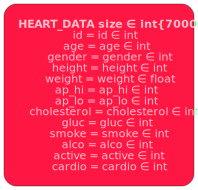

In [5]:
import graphviz

def display_dot(dot_graph): 
    display(graphviz.Source(dot_graph))

ds = qdb.dataset()
display_dot(ds.relations()[0][1].dot())

The `Relation` object holds information about columns and their associated Qrlew [data types](https://github.com/Qrlew/qrlew/blob/b4960d57b7ac047b525c36b9cb9eb3395e0f4029/src/data_type/mod.rs#L2207) (including bounds).

These Qrlew data types are transformed from the database's original types. 
Therefore, when importing data from sources like CSV files or pandas DataFrames that lack support for certain types (such as bytes or lists), 
you may sacrifice the detailed distinctions that Qrlew offers.

## Bound the columns of a table

We adopt the perspective of the data owner, who aims to safeguard user privacy. We focus on a subset of the heart_data containing four columns:

- `id` (integer):  contains unique identifiers, which must remain confidential,
- `gender` (integer): 1 (Male) or 2 (Female),
- `height` (integer), 
- `weight` (integer).

We need to bounds the `height` and `weight` columns. 
We can limit the height to a range of 140 to 200 and the weight to a range of 40 to 130 kg.


The data preparation involves creating a new dataset with specific column transformations:
- `id` (integer): remains unchanged
- `gender` (string): exclude values other than 1 or 2 then replace 0 with 'M', 1 with 'F',
- `height` (float): exclude values outside the range [140.0, 200.0],
- `weight` (float): exclude values outside the range [40.0, 130.0].

This preparation can be transcripted as an SQL query: 

In [6]:
query = """
WITH 
    bounds_table AS (SELECT 
        id, 
        height, 
        weight,
        CASE WHEN id = 1 THEN 'M' ELSE 'F' END AS gender
    FROM heart_data
    WHERE 
        height > 140. AND height < 200. AND
        weight > 40. AND weight < 130. AND
        gender IN (1, 2)
    )
SELECT * FROM bounds_table
"""

We define a new `Relation` that mirrors the dataset's SQL query operation:

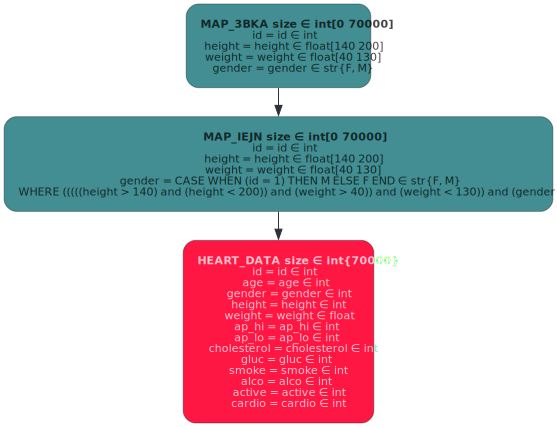

In [7]:
relation = ds.sql(query)
display_dot(relation.dot())

At the basis in red, we find the original table `heart_data` with all its columns. 

The first mapping operation involves selecting the `id`, `gender`, `height` and `weight` columns and coercing their types. 

The output `Relation` contains the four columns with their datatypes propagated:

- The `gender` column has `str` type with only two possible values `M` and `F`.
- The `height` and `weigh` columns contain bounded floats. 

In [8]:
print(f"The propagated datatype is: {relation.schema()}")  

The propagated datatype is: {id: int, height: float[140 200], weight: float[40 130], gender: str{F, M}}


Importantly, these data types have been extended **independently, without necessitating any interaction with the database**. 

At this stage, the computation of aggregation sensitivity becomes feasible, but exclusively when such aggregation is executed on one of the initial columns.


## Range propagation

When confronted with the aggregation of composite columns, one approach to gauge sensitivity involves employing the automatic bounds determination algorithm introduced by [Wilson et al. (2019)](https://arxiv.org/abs/1909.01917). 

However, a drawback of this method is that it consumes half of the privacy budget allocated for the aggregation.

In the next section, we'll delve into how Qrlew extends the boundaries of the initial columns to composite columns without spending any privacy budget.

As a first example, we reuse the previous query and compute the BMI (Body Mass Index) using the formula: 
$BMI = \frac{weight(kg)}{height(m)^2}$.

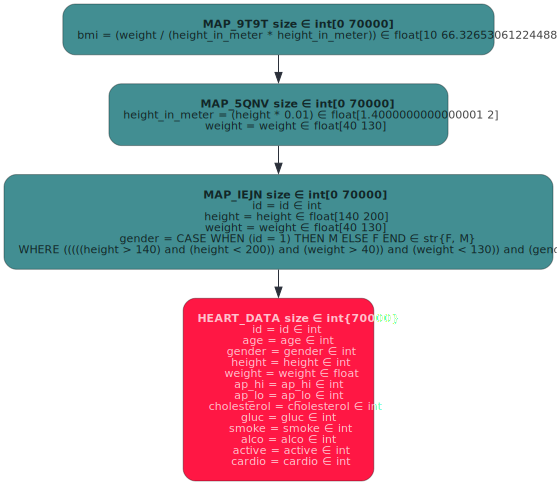

In [9]:
query = """
WITH 
    bounds_table AS (
        SELECT 
            id, 
            height, 
            weight,
            CASE WHEN id = 1 THEN 'M' ELSE 'F' END AS gender
        FROM heart_data
        WHERE 
            height > 140 AND height < 200 AND
            weight > 40.00 AND weight < 130. AND
            gender IN (1, 2)
    ),
    convert_table AS (
        SELECT 
            height * 0.01 AS height_in_meter,  
            weight
        FROM bounds_table
    )
SELECT weight / (height_in_meter * height_in_meter) AS bmi FROM convert_table
"""
relation = ds.sql(query)
display_dot(relation.dot())

The two lower relations are the ones we previously had, which are fed into a new `Relation` that performs the conversion of the `height` column from centimeters to meters. 

The updated ranges are automatically calculated as `[140, 200] -> [1.4, 2.0]`.

The BMI computation takes place in the uppermost `Relation`, the corresponding ranges are:
$$
\left [ \frac{\min (weight(kg))}{\max (height(m)^2)}, \frac{\max (weight(kg))}{\min (height(m)^2)} \right] 
$$

In [10]:
relation.schema()

'{bmi: float[10 66.32653061224488]}'

This can be converted to the true min and max: 

In [11]:
df = pd.DataFrame(qdb.eval(relation))
print(f"bmi: [{df['bmi'].min()}, {df['bmi'].max()}]")


bmi: [14.527376033057852, 63.975401706010715]


We observe that the estimated bounds encompass the actual bounds. This implies that we might be introducing an excessive amount of noise. If we aim to incorporate less noise, we can tighten the bounds; however, this adjustment could potentially introduce bias into the final outcome.

Let now consider another example. We want to compute the Lorentz fomula given by:

$$
\left\{
    \begin{array}{ll}
        0.75 * height - 62.5 & \text{if  gender='M'} \\
        0.60 * height -40.0 & \text{if  gender='F'} \\
    \end{array}
\right.
$$

**To illustrate the process of joining**, we calculate the Lorentz formula separately for males and females using two distinct common table expressions. 
Subsequently, we merge these tables through a join operation and retrieve the appropriate formula based on the individual's gender.

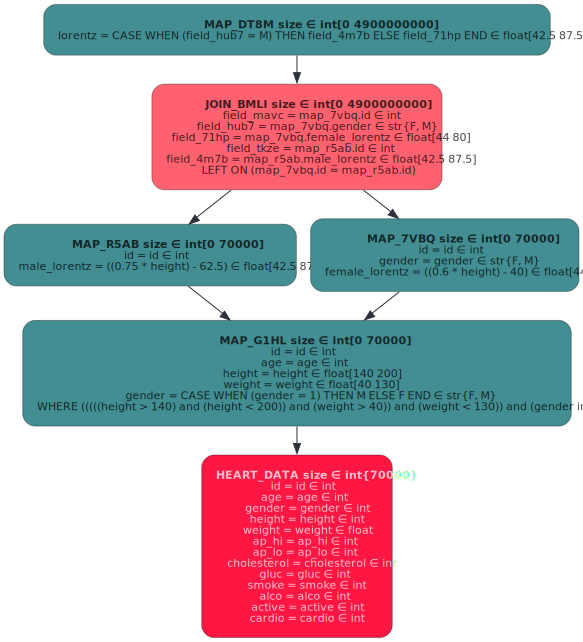

In [12]:
query = """
WITH 
    bounds_table AS (
        SELECT 
            id, 
            age, 
            height, 
            weight,
            CASE WHEN gender = 1 THEN 'M' ELSE 'F' END AS gender
        FROM heart_data
        WHERE 
            height > 140 AND height < 200 AND
            weight > 40.00 AND weight < 130. AND
            gender IN (1, 2)
    ),
    female_table AS (
        SELECT 
            id, 
            gender,
            0.6 * height -40.0 AS female_lorentz
        FROM bounds_table
    ),
    male_table AS (
        SELECT 
            id, 
            0.75 * height - 62.5 AS male_lorentz
        FROM bounds_table
    )
SELECT CASE WHEN gender = 'M' THEN male_lorentz else female_lorentz END AS lorentz FROM female_table LEFT JOIN male_table ON female_table.id = male_table.id
"""
relation = ds.sql(query) 

display_dot(relation.dot())

Once more, in this example, you can trace follow the propagation of the ranges as they propagate throughout all the relations.

Finally, the propagated ranges for the Lorentz formula are:

In [13]:
relation.schema()

'{lorentz: float[42.5 87.5]}'

The exact ranges are: 

In [14]:
df = pd.DataFrame(qdb.eval(relation))
print(f"lorentz: [{df['lorentz'].min()}, {df['lorentz'].max()}]")


lorentz: [43.25, 86.0]


In certain scenarios, when there's a high correlation between columns, it might not be advisable to use propagated ranges. 
This is because the accurate range could be influenced by significant correlations that are not evident from external data. 
In such instances, it could be beneficial to allocate budget towards computing ranges using the automatic boundary determination algorithm ([Wilson et al. 2019](https://arxiv.org/abs/1909.01917)).

However, how can an analyst without free database access determine whether he should allocate budget to compute the ranges?

This is where utilizing Sarus becomes advantageous. 

By employing [Sarus](https://www.sarus.tech/), the analyst gains **access to a synthetic dataset** wherein inter-column correlations are replicated.

This empowers the analyst to **devise a strategy without expending privacy resources**, as they can scrutinize the synthetic dataset for insights and make informed decisions.